In [1]:
!pip install d2l==0.16

     |████████████████████████████████| 76 kB 4.6 MB/s 


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [3]:
torch.set_printoptions(2)#精简打印精度

假设输入图像的高度为  h ，宽度为  w 。 我们以图像的每个像素为中心生成不同形状的锚框：比例 为  s∈(0,1] ，宽高比（宽高比）为  r>0 。 那么锚框的宽度和高度分别是  wsr√  和  hs/r√ 。 请注意，当中心位置给定时，已知宽和高的锚框是确定的。

要生成多个不同形状的锚框，让我们设置一系列刻度  s1,…,sn  和一系列宽高比  r1,…,rm 。 当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有  whnm  个锚框。 尽管这些锚框可能会覆盖所有地面真实边界框，但计算复杂性很容易过高。 在实践中，我们只考虑包含  s1  或  r1  的组合：

(13.4.1)
(s1,r1),(s1,r2),…,(s1,rm),(s2,r1),(s3,r1),…,(sn,r1).
 
也就是说，以同一像素为中心的锚框的数量是  n+m−1 。 对于整个输入图像，我们将共生成  wh(n+m−1)  个锚框。

上述生成锚框的方法可以在以下 multibox_prior 函数中实现。 我们指定输入图像、尺度列表和宽高比列表，然后此函数将返回所有的锚框。

In [4]:
def multibox_prior(data,sizes,ratios):
  """生成以每个像素为中心具有不同形状的锚框"""
  in_height,in_width=data.shape[-2:]
  device,num_sizes,num_ratios=data.device,len(sizes),len(ratios)
  boxes_per_pixel=(num_sizes+num_ratios-1)
  size_tensor=torch.tensor(sizes,device=device)
  ratio_tensor=torch.tensor(ratios,device=device)
  # 为了将锚点移动到像素的中心，需要设置偏移量。
  # 因为一个像素的的高为1且宽为1，我们选择偏移我们的中心0.5
  offset_h,offset_w=0.5,0.5
  steps_h=1.0/in_height
  steps_w=1.0/in_width
  # 生成锚框的所有中心点
  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
  shift_y,shift_x=torch.meshgrid(center_h,center_w)
  shift_y,shift_x=shift_y.reshape(-1),shift_x.reshape(-1)

  # 生成“boxes_per_pixel”个高和宽，
  # 之后用于创建锚框的四角坐标 (xmin, xmax, ymin, ymax)
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
          sizes[0] * torch.sqrt(ratio_tensor[1:])))\
          * in_height / in_width  # Handle rectangular inputs
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
          sizes[0] / torch.sqrt(ratio_tensor[1:])))
  # 除以2来获得半高和半宽
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
  # 每个中心点都将有“boxes_per_pixel”个锚框，
  # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  output = out_grid + anchor_manipulations
  return output.unsqueeze(0)

返回锚框变量Y的形状

In [5]:
img=d2l.plt.imread('/content/drive/MyDrive/d2l-zh-master/img/catdog.jpg')
h,w=img.shape[:2]

print(h,w)
X=torch.rand(size=(1,3,h,w))
Y=multibox_prior(X,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

将锚框变量 Y 的形状更改为（图像高度、图像宽度、以同一像素为中心的锚框的数量，4）后，我们就可以获得以指定像素的位置为中心的所有锚框了。 在接下来的内容中，我们访问以 (250, 250) 为中心的第一个锚框。 它有四个元素：锚框左上角的  (x,y)  轴坐标和右下角的  (x,y)  轴坐标。 将两个轴的坐标分别除以图像的宽度和高度后，所得的值就介于 0 和 1 之间。

In [6]:
boxes=Y.reshape(h,w,5,4)
boxes[250,250,0,:]

tensor([0.06, 0.07, 0.63, 0.82])

为了显示以图像中一个像素为中心的所有锚框，我们定义了以下 show_bboxes 函数来在图像上绘制多个边界框。

In [7]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框。"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

以(250，250)为中心的所有锚框

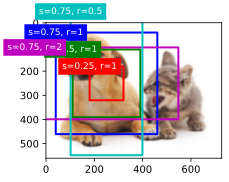

In [8]:
d2l.set_figsize()
bbox_scale=torch.tensor((w,h,w,h))
fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,boxes[250,250,:,:] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [9]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比。"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # `boxes1`, `boxes2`, `areas1`, `areas2`的形状:
    # `boxes1`：(boxes1的数量, 4),
    # `boxes2`：(boxes2的数量, 4),
    # `areas1`：(boxes1的数量,),
    # `areas2`：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    #  `inter_upperlefts`, `inter_lowerrights`, `inters`的形状:
    # (boxes1的数量, boxes2的数量, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # `inter_areas` and `union_areas`的形状: (boxes1的数量, boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

给定图像，假设锚框是  A1,A2,…,Ana ，真实边界框是  B1,B2,…,Bnb ，其中  na≥nb 。 让我们定义一个矩阵  X∈Rna×nb ，其中  ith  行和  jth  列中的元素  xij  是锚框  Ai  和真实边界框  Bj 的 IoU 。 该算法包含以下步骤：

在矩阵  X  中找到最大的元素，并将它的行索引和列索引分别表示为  i1  和  j1 。然后将真实边界框  Bj1  分配给锚框  Ai1 。这很直观，因为  Ai1  和  Bj1  是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中  i1th  行和  j1th  列中的所有元素。

在矩阵  X  中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为  i2  和  j2 。我们将真实边界框  Bj2  分配给锚框  Ai2  ，并丢弃矩阵中  i2th  行和  j2th  列中的所有元素。

此时，矩阵  X  中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵  X  中  nb  列中的所有元素。此时，我们已经为这  nb  个锚框各自分配了一个真实边界框。

只遍历剩下的  na−nb  个锚框。例如，给定任何锚框  Ai ，在矩阵  X  的第  ith  行中找到与  Ai  的IoU最大 的真实边界框  Bj  ，只有当此 IoU 大于预定义的阈值时，才将  Bj  分配给  Ai 。

让我们用一个具体的例子来说明上述算法。 如 图13.4.2（左）所示，假设矩阵  X  中的最大值为  x23 ，我们将真实边界框  B3  分配给锚框  A2 。 然后，我们丢弃矩阵第 2 行和第 3 列中的所有元素，在剩余元素（阴影区域）中找到最大的  x71 ，然后将真实边界框  B1  分配给锚框  A7 。 接下来，如 图13.4.2（中）所示，丢弃矩阵第 7 行和第 1 列中的所有元素，在剩余元素（阴影区域）中找到最大的  x54 ，然后将真实边界框  B4  分配给锚框  A5 。 最后，如 图13.4.2（右）所示，丢弃矩阵第 5 行和第 4 列中的所有元素，在剩余元素（阴影区域）中找到最大的  x92 ，然后将真实边界框  B2  分配给锚框  A9 。 之后，我们只需要遍历剩余的锚框  A1,A3,A4,A6,A8 ，然后根据阈值确定是否为它们分配真实边界框。

../_images/anchor-label.svg
图13.4.2 将真实边界框分配给锚框。

此算法在以下 assign_anchor_to_bbox 函数中实现。

In [10]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框。"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素 x_ij 是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

现在我们可以为每个锚框标记分类和偏移量了。 假设一个锚框  A  被分配了一个真实边界框  B 。 一方面，锚框  A  的类将被标记为与  B  相同。 另一方面，锚框  A  的偏移量将根据  B  和  A  中心坐标的相对位置、以及这两个框的相对大小进行标记。 鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得更均匀分布、易于适应的偏移量。 在这里，我们介绍一种常见的变换。 给定框  A  和  B ，中心坐标分别为  (xa,ya)  和  (xb,yb) ，宽度分别为  wa  和  wb ，高度分别为  ha  和  hb 。 我们可以将  A  的偏移量标记为

其中常量的默认值是  μx=μy=μw=μh=0,σx=σy=0.1  和  σw=σh=0.2 。 这种转换在下面的 offset_boxes 函数中实现。

In [11]:
def offset_boxes(anchors,assigned_bb,eps=1e-6):
  """对锚框偏移量的转换"""
  c_anc=d2l.box_corner_to_center(anchors)
  c_assigned_bb=d2l.box_corner_to_center(assigned_bb)
  offset_xy=10*(c_assigned_bb[:,:2]-c_anc[:,:2])/c_anc[:,2:]
  offset_wh=5*torch.log(eps+c_assigned_bb[:,2:]/c_anc[:,2:])
  offset=torch.cat([offset_xy,offset_wh],axis=1)
  return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类标记为 “背景”类。 背景类的锚框通常被称为“负类”锚框，其余的被称为“正类”锚框。 我们使用真实边界框（ labels 参数）实现以下 multibox_target 函数，来标记锚框的类和偏移量（ anchors 参数）。 此函数将背景类设置为零，然后将新类的整数索引递增一。

In [20]:
def multibox_target(anchors,labels):
  """使用真实边界框标记锚框"""
  batch_size,anchors=labels.shape[0],anchors.squeeze(0)
  batch_offset,batch_mask,batch_class_labels=[],[],[]
  device,num_anchors=anchors.device,anchors.shape[0]
  for i in range(batch_size):
    label=labels[i,:,:]
    anchors_bbox_map=assign_anchor_to_bbox(
        label[:,1:],anchors,device)
    bbox_mask=((anchors_bbox_map>=0).float().unsqueeze(-1)).repeat(1,4)
    #将类标签和分配的边界框坐标初始化为0
    class_labels=torch.zeros(num_anchors,dtype=torch.long,device=device)
    assigned_bb=torch.zeros((num_anchors,4),dtype=torch.float32,device=device)
    #使用真实边界框来标记锚框的类别，
    #如果一个锚框没有被分配，我们标记其维背景
    indices_true=torch.nonzero(anchors_bbox_map>=0)
    bb_idx=anchors_bbox_map[indices_true]
    class_labels[indices_true]=label[bb_idx,0].long()+1
    assigned_bb[indices_true]=label[bb_idx,1:]
    #偏移量转换
    offset=offset_boxes(anchors,assigned_bb)*bbox_mask
    batch_offset.append(offset.reshape(-1))
    batch_mask.append(bbox_mask.reshape(-1))
    batch_class_labels.append(class_labels)
  bbox_offset = torch.stack(batch_offset)
  bbox_mask = torch.stack(batch_mask)
  class_labels = torch.stack(batch_class_labels)
  return(bbox_offset,bbox_mask,class_labels)#分别对应锚框与真实标注框的偏差、
  #是否为背景（0为背景，1为真实的框）、如果是真实边框对应的类别

让我们通过一个具体的例子来说明锚箱标签。 我们在加载的图像中为狗和猫定义了地面真实边界框，其中第一个元素是类（0 代表狗，1 代表猫），其余四个元素是左上角和右下角的  (x,y)  轴坐标（范围介于 0 和 1 之间）。 我们还构建了五个锚框，用左上角和右下角的坐标进行标记： A0,…,A4 （索引从 0 开始）。 然后我们在图像中绘制这些地面真相边界框和锚框。

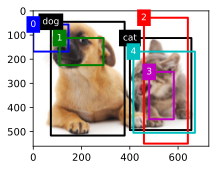

In [13]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig=d2l.plt.imshow(img)
show_bboxes(fig.axes,ground_truth[:,1:]*bbox_scale,['dog','cat'],'k')
show_bboxes(fig.axes,anchors*bbox_scale,['0','1','2','3','4']);

使用上面定义的 multibox_target 函数，我们可以根据狗和猫的真实边界框，标注这些锚框的分类和偏移量。 在这个例子中，背景、狗和猫的类索引分别为 0、1 和 2。 下面我们为锚框和真实边界框范例添加了维度。

In [21]:
labels = multibox_target(anchors.unsqueeze(dim=0),ground_truth.unsqueeze(dim=0))

返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类。

让我们根据图像中的锚框和真实边界框的位置来分析下面返回的类标签。 首先，在所有的锚框和真实边界框配对中，锚框  A4  与猫的真实边界框的 IoU 是最大的。 因此， A4  的类被标记为猫。 去除包含  A4  或猫的真实边界框的配对，在剩下的配对中，锚框  A1  和狗的真实边界框有最大的 IoU。 因此， A1  的类被标记为狗。 接下来，我们需要遍历剩下的三个未标记的锚框： A0 、 A2  和  A3 。 对于  A0 ，与其拥有最大 IoU 的真实边界框的类是狗，但 IoU 低于预定义的阈值 (0.5)，因此该类被标记为背景； 对于 A2 ，与其拥有最大 IoU 的真实边界框的类是猫，IoU 超过阈值，所以类被标记为猫； 对于  A3 ，与其拥有最大 IoU 的真实边界框的类是猫，但值低于阈值，因此该类被标记为背景。

In [23]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [24]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

在预测期间，我们先为图像生成多个锚框，再为这些锚框一一预测类别和偏移量。 一个“预测好的边界框”则根据其中某个带有预测偏移量的锚框而生成。 下面我们实现了 offset_inverse 函数，该函数将锚框和偏移量预测作为输入，并应用逆偏移变换来返回预测的边界框坐标。

In [25]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框。"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。 为了简化输出，我们可以使用 非极大值抑制 (non-maximum suppression，NMS)合并属于同一目标的类似的预测边界框。

以下是非极大值抑制的工作原理。 对于一个预测边界框  B ，目标检测模型会计算每个类的预测概率。 假设最大的预测概率为  p  ，则该概率所对应的类别  B  即为预测的类别。 具体来说，我们将  p  称为预测边界框  B  的置信度。 在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表  L 。然后我们通过以下步骤操作排序列表  L ：

从  L  中选取置信度最高的预测边界框  B1  作为基准，然后将所有与  B1  的IoU 超过预定阈值  ϵ  的非基准预测边界框从  L  中移除。这时， L  保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有 非极大值 置信度的边界框被 抑制 了。

从  L  中选取置信度第二高的预测边界框  B2  作为又一个基准，然后将所有与  B2  的IoU大于  ϵ  的非基准预测边界框从  L  中移除。

重复上述过程，直到  L  中的所有预测边界框都曾被用作基准。此时，  L  中任意一对预测边界框的IoU都小于阈值  ϵ  ；因此，没有一对边界框过于相似。

输出列表  L  中的所有预测边界框。

以下 nms 函数按降序对置信度进行排序并返回其索引。

In [26]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序。"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

我们定义以下 multibox_detection 函数来将非极大值抑制应用于预测边界框。 如果你发现实现有点复杂，请不要担心：我们将在实现之后，马上用一个具体的示例来展示它是如何工作的。

In [27]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框。"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的 non_keep 索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # `pos_threshold` 是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

现在让我们将上述算法应用到一个带有四个锚框的具体示例中。 为简单起见，我们假设预测的偏移量都是零，这意味着预测的边界框即是锚框。 对于背景、狗和猫其中的每个类，我们还定义了它的预测概率。

In [28]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

我们可以在图像上绘制这些预测边界框和置信度

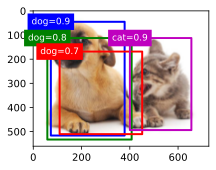

In [29]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

现在我们可以调用 multibox_detection 函数来执行非极大值抑制，其中阈值设置为 0.5。 请注意，我们在示例的张量输入中添加了维度。

我们可以看到返回结果的形状是（批量大小，锚框的数量，6）。 最内层维度中的六个元素提供了同一预测边界框的输出信息。 第一个元素是预测的类索引，从 0 开始（0代表狗，1代表猫），值 -1 表示背景或在非极大值抑制中被移除了。 第二个元素是预测的边界框的置信度。 其余四个元素分别是预测边界框左上角和右下角的  (x,y)  轴坐标（范围介于 0 和 1 之间）。

In [30]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

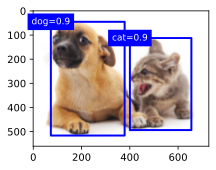

In [31]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)